# Insights


#### Introduction 

Released on October 27, 2009, League of Legends (LoL) is a multiplayer online battle arena video game developed and published by Riot Games for Microsoft Windows and macOS. 

LOL is a complex game where 5 players of the blue team are fighting 5 players of the red team in a cruel match.

Each team works together to achieve victory either by destroying the enemy team's Nexus, after bypassing a line of defensive structures called turrets or towers, or by forcing the enemy team to surrender through a vote.

With that being said, the dataset used in this project contains the early game (first 10mins of the game) stats of approx. 10k high ELO ranked games.


#### Dataset columns

blueWins: Blue Team wins or loses

WardsPlaced: Number of warding totems placed by the team on the map

WardsDestroyed : Number of enemy warding totems the team has destroyed

FirstBlood: First kill of the game. 1 if the team got the first kill, 0 if not

Kills: Number of enemies killed by the team

Deaths: Number of deaths

Assists: Number of kill assists

EliteMonsters: Number of elite monsters killed by the team (Dragons and Heralds)

Dragons: Number of dragons killed by the team

Heralds : Number of heralds killed by the team

TowersDestroyed: Number of structures destroyed by the team

TotalGold: Team total gold

AvgLevel: Team average champion level

TotalExperience: Team total experience

TotalMinionsKilled: Team total minions killed (CS)

TotalJungleMinionsKilled: Team total jungle monsters killed

GoldDiff: Team gold difference compared to the enemy team

ExperienceDiff: Team experience difference compared to the enemy team

CSPerMin: Team CS (minions) per minute

GoldPerMin: Team gold per min

#### Objective 

The aim of this project is to train and test several classification algorithms and choose the best one to be used to predict the outcome of a match based solely on the early game stats.

# Imports

In [3]:
#Data loading and visualization imports

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mplt
import seaborn as sns
%matplotlib inline

# Loading data

In [4]:
lol_df = pd.read_csv('high_diamond_ranked_10min.csv')

lol_df.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


# Data pre-processing

In [5]:
# General informations

lol_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

The dataset contains 9879 entries (matches) with a total of 40 columns providing both red and blue team stats. In addition to a target column "blueWins" that determines which of one of the teams actually ended up winning.

##### Note:
All features values seem to be numerical (floats or ints) so it is safe to assume that feature transformation step can be skipped

In [6]:
# Looking for missing values

lol_df.isnull().sum().sum()

0

Data contains no missing values

In [7]:
# Dropping gameId column 

lol_df.drop( labels = ['gameId',], axis = 1, inplace = True)

In [8]:
# Spliting blue team and red team stats

bt_stats = lol_df.iloc[:, 1:20]

rt_stats = lol_df.iloc[:, 20:]

#### For the rest of the work  we will focus only on visualising the blue team stats and building a prediction model for the blue team since predicting a team's win/loss is predicting the other team's win/loss as well.

# Data visualisation

The purpose of this part is to get a grasp on the different relations between a team's win/loss and the stats contributing to that particular outcome

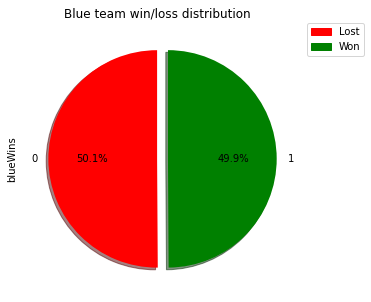

In [9]:
# win/loss distribution

plt.figure(figsize = (10,5))
plt.title('Blue team win/loss distribution')
#sns.countplot(lol_df.blueWins, palette = ['r', 'g'])
lol_df.blueWins.value_counts().plot.pie( colors = ['r', 'g'], autopct = "%1.1f%%", explode = (0, 0.1), 
                                           shadow = True, startangle = 90 )
plt.legend(bbox_to_anchor = (1.05, 1), loc = "upper left", borderaxespad = 0.,handles = [mplt.patches.Patch(color = "r", label = 'Lost'),mplt.patches.Patch(color = "g",label = 'Won')])


The dataset is well balanced and we almost have the same number of won and lost games.

First blood is a very important even that may put a team ahead of their opponents. We'll take a look at the winning chances if the blue team got first blood.

In [18]:
win_prob = lol_df.groupby('blueFirstBlood')['blueWins'].mean()
win_prob = win_prob.reset_index()
win_prob.columns = ['blueFirstBlood', 'win_prob']

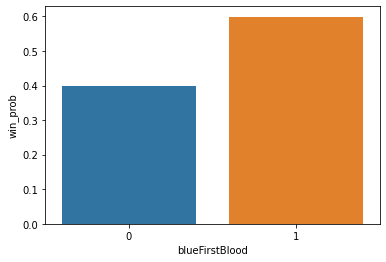

In [19]:
sns.barplot(x = 'blueFirstBlood', y = 'win_prob', data = win_prob)

Obviously, the team has a better chance of winning when they get first blood due to the momentum swing and the extras gold and exp given.